# Upload Datasets

11-10-24

In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
'''LOL V1 '''

'LOL V1 '

In [4]:
# imports
import os
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
# load paths
train_high = '/kaggle/input/og-lol-v1/our485/high'
test_high = '/kaggle/input/og-lol-v1/eval15/high'

train_low = '/kaggle/input/og-lol-v1/our485/low'
test_low = '/kaggle/input/og-lol-v1/eval15/low'

In [6]:
# define function to load all image pairs
def load_all_image_pairs(low_path, high_path):
    low_images = sorted([os.path.join(low_path, img) for img in os.listdir(low_path)])
    high_images = sorted([os.path.join(high_path, img) for img in os.listdir(high_path)])
    return low_images, high_images

In [7]:
# Check if the directories are loaded properly
print("Train low-light images: ", len(os.listdir(train_low)))
print("Train sufficient-light images: ", len(os.listdir(train_high)))
print("Test low-light images: ", len(os.listdir(test_low)))
print("Train sufficient-light images: ", len(os.listdir(test_high)))

Train low-light images:  485
Train sufficient-light images:  485
Test low-light images:  15
Train sufficient-light images:  15


In [8]:
# load all train and validation image pairs
train_low_images, train_high_images = load_all_image_pairs(train_low, train_high)
test_low_images, test_high_images = load_all_image_pairs(test_low, test_high)

In [9]:
# Print the number of image pairs loaded
print(f"Total training low-light image pairs: {len(train_low_images)}")
print(f"Total training sufficient-light image pairs: {len(train_high_images)}")

print(f"Total test low-light image pairs: {len(test_low_images)}")
print(f"Total test sufficient-light image pairs: {len(test_high_images)}")

Total training low-light image pairs: 485
Total training sufficient-light image pairs: 485
Total test low-light image pairs: 15
Total test sufficient-light image pairs: 15


In [10]:
# Function to load and display image pairs
def load_image_pair(low_img_path, high_img_path):
    low_image = Image.open(low_img_path)
    high_image = Image.open(high_img_path)

    # Display both images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(low_image)
    axes[0].set_title('Low-Light Image')
    axes[0].axis('off')

    axes[1].imshow(high_image)
    axes[1].set_title('Sufficient-Light Image')
    axes[1].axis('off')

    plt.show()

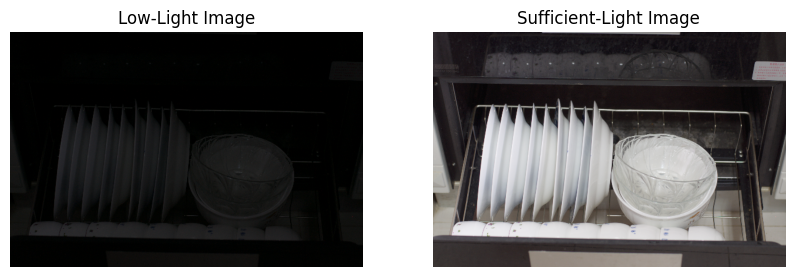

In [11]:
# Display first train image pair
load_image_pair(train_low_images[1], train_high_images[1])

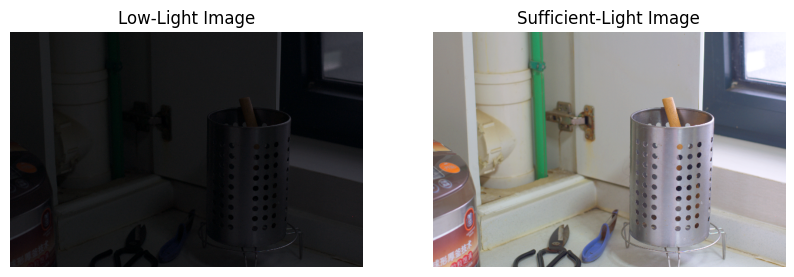

In [12]:
# Display first test image pair
load_image_pair(test_low_images[1], test_high_images[1])

# Architecture

In [13]:
'''HVI transform - define a class which will include functions pertaining to color-space related operations'''

'HVI transform - define a class which will include functions pertaining to color-space related operations'

In [14]:
import torch
import torch.nn as nn

In [15]:
pi = 3.141592653589793

In [16]:
class RGB_HVI(nn.Module):
    def __init__(self):
        super(RGB_HVI, self).__init__()
        self.density_k = torch.nn.Parameter(torch.full([1],0.2)) #define trainable parameter k. Here k is reciprocal to the one mentioned in the paper
        self.this_k = 0 #to track the value of k

    def HVIT(self, img):
        eps = 1e-8 #define hyperparam epsilon as mentioned in paper
        device = img.device
        dtypes = img.dtype

        hue = torch.Tensor(img.shape[0], img.shape[2],img.shape[3]).to(device).to(dtypes) #initialize hue

        value = img.max(1)[0].to(dtypes) #value is simply intensity,i.e max value among R,G and B values
        img_min = img.min(1)[0].to(dtypes)

        #computation of hue:
        hue[img[:,2]==value] = 4.0 + ( (img[:,0]-img[:,1]) / (value - img_min + eps)) [img[:,2]==value]
        hue[img[:,1]==value] = 2.0 + ( (img[:,2]-img[:,0]) / (value - img_min + eps)) [img[:,1]==value]
        hue[img[:,0]==value] = (0.0 + ((img[:,1]-img[:,2]) / (value - img_min + eps)) [img[:,0]==value]) % 6

        hue[img.min(1)[0]==value] = 0.0
        hue = hue/6.0 # normalize

        #saturation
        saturation = (value - img_min) / (value + eps)
        saturation[value == 0] = 0
        
        #define gamma_g and gamma_b
        
        #define P_gamma ( piecewise function of gamma_g and gamma_b )

        #adding a channel dimension to each
        hue = hue.unsqueeze(1)
        saturation = saturation.unsqueeze(1)
        value = value.unsqueeze(1)

        k = self.density_k
        self.this_k = k.item()

        #define Ck
        color_sensitive = ((value * 0.5* pi).sin() + eps).pow(k)

        # define h and v by orthogonalizing hue
        # replace hue by P_gamma in cx and cy formula
        cx = (2.0 * pi * hue).cos()
        cy = (2.0 * pi * hue).sin()
        
        #define T

        #define X,Y,Z axes - add Dt term 
        X = color_sensitive * saturation * cx
        Y = color_sensitive * saturation * cy
        Z = value

        xyz = torch.cat([X,Y,Z], dim=1) # Combine the three components into a single tensor with 3 channels
        return xyz

    def PHVIT(self, img):
        eps = 1e-8
        H,V,I = img[:,0,:,:],img[:,1,:,:],img[:,2,:,:] #access each of H,V,I color spaces from 'channel' dimension

        # initialize gate options to False
        self.gated = False
        self.gated2 = False
        self.alpha = 1.0 #initialize hyperparam value to 1


        #clip
        H = torch.clamp(H,-1,1)
        V = torch.clamp(V,-1,1)
        I = torch.clamp(I,0,1)

        v = I #I in HSV = V in HSV
        k = self.this_k
        color_sensitive = ((v * 0.5 * pi).sin() + eps).pow(k)

        #normalize H and V values by Ck
        H = (H) / (color_sensitive + eps)
        V = (V) / (color_sensitive + eps)

        #clip
        H = torch.clamp(H,-1,1)
        V = torch.clamp(V,-1,1)

        #compute hue
        h = torch.atan2(V,H) / (2*pi)
        h = h%1

        #compute saturation
        s = torch.sqrt(H**2 + V**2 + eps)

        #enable gating
        if self.gated:
            magnification = 1.3
            s = s * magnification # artificially increasing the saturation for more vibrant colors.

        #clip
        s = torch.clamp(s,0,1)
        v = torch.clamp(v,0,1)

        #convert HSV to RGB using a standard conversion formula:

        #set up r,g,b variables
        r = torch.zeros_like(h)
        g = torch.zeros_like(h)
        b = torch.zeros_like(h)

        # scale to an integer value between 0 and 5, representing the six sections of the HSV color wheel.
        hi = torch.floor(h * 6.0)

        # fractional part of h
        f = h * 6.0 - hi
        p = v * (1. - s)
        q = v * (1. - (f * s))
        t = v * (1. - ((1. - f) * s))

        hi0 = hi==0
        hi1 = hi==1
        hi2 = hi==2
        hi3 = hi==3
        hi4 = hi==4
        hi5 = hi==5

        # assign values of r, g, and b depending on which sector the hue falls into
        r[hi0] = v[hi0]
        g[hi0] = t[hi0]
        b[hi0] = p[hi0]

        r[hi1] = q[hi1]
        g[hi1] = v[hi1]
        b[hi1] = p[hi1]

        r[hi2] = p[hi2]
        g[hi2] = v[hi2]
        b[hi2] = t[hi2]

        r[hi3] = p[hi3]
        g[hi3] = q[hi3]
        b[hi3] = v[hi3]

        r[hi4] = t[hi4]
        g[hi4] = p[hi4]
        b[hi4] = v[hi4]

        r[hi5] = v[hi5]
        g[hi5] = p[hi5]
        b[hi5] = q[hi5]

        #expand r,g,b values along the channel dimension
        r = r.unsqueeze(1)
        g = g.unsqueeze(1)
        b = b.unsqueeze(1)

        #concatenate to form a 3-channel RGB image
        rgb = torch.cat([r,g,b], dim=1)

        #enable gating
        if self.gated2:
            rgb = rgb * self.alpha

        return rgb

12-10-24

In [17]:
'''Define class for Layer Normalization'''

'Define class for Layer Normalization'

In [18]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

In [20]:
# implementing that version of LayerNorm where the 'vanilla' LayerNorm has an extra weight-bias pair

In [21]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.ones(normalized_shape))
        self.eps = eps
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        # Permute to [batch_size, height, width, channels] for layer normalization
        x = x.permute(0, 2, 3, 1)
        # Apply layer normalization on the channels dimension (last dimension)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        # Permute back to [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2)
        return x

In [22]:
#define NormDownsample
class NormDownsample(nn.Module):
    def __init__ (self, in_ch, out_ch, scale=0.5, use_norm=False):
        super(NormDownsample, self).__init__()

        self.use_norm = use_norm

        if self.use_norm:
            self.norm = LayerNorm(out_ch)
        self.selu = nn.SELU()
        self.down = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
        nn.UpsamplingBilinear2d(scale_factor=scale))

    def forward(self, x):
#         print(f"NormDownsample input shape: {x.shape}")  # Added
        x = self.down(x)
#         print(f"NormDownsample after downsample: {x.shape}")  # Added
        x = self.selu(x)
        if self.use_norm:
            x = self.norm(x)
#             print(f"NormDownsample after normalization: {x.shape}")  # Added
            return x
        else:
#             print(f"NormDownsample after normalization: {x.shape}")  # Added
            return x

In [23]:
#define NormUpsample
class NormUpsample(nn.Module):
    def __init__(self, in_ch, out_ch, scale=2, use_norm=False):
        super(NormUpsample, self).__init__()
        self.use_norm = use_norm
        if self.use_norm:
            self.norm = LayerNorm(out_ch)
        self.selu = nn.SELU()
        self.up_scale = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,kernel_size=3,stride=1, padding=1, bias=False),
            nn.UpsamplingBilinear2d(scale_factor=scale))
        self.up = nn.Conv2d(out_ch*2, out_ch, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x, y):
#         print(f"NormUpsample input x shape: {x.shape}, y shape: {y.shape}")  # Added
        x = self.up_scale(x)
#         print(f"NormUpsample after up_scale: {x.shape}")  # Added
        x = torch.cat([x,y], dim=1)
#         print(f"NormUpsample after concatenation: {x.shape}")  # Added
        x = self.up(x)
        x = self.selu(x)
        if self.use_norm:
            return self.norm(x)
#             print(f"NormUpsample after normalization: {x.shape}")  # Added
        else:
#             print(f"NormUpsample after normalization: {x.shape}")  # Added
            return x

In [24]:
'''define class for LCA Module - Lightweight/Lighten Cross Attention Module'''

'define class for LCA Module - Lightweight/Lighten Cross Attention Module'

In [25]:
'''define cross-attention block'''

'define cross-attention block'

In [26]:
#cross attention block
class CAB(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(CAB, self).__init__()
        self.num_heads = num_heads

        self.q = nn.Conv2d(dim, dim, kernel_size=1, bias=bias) #normal conv
        self.q_dwconv = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, groups=dim, bias=bias) #depth-wise conv

        self.kv = nn.Conv2d(dim, dim*2, kernel_size=1, bias=bias)
        self.kv_dwconv = nn.Conv2d(dim*2, dim*2, kernel_size=3, stride=1, padding=1, groups=dim*2, bias=bias)

        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias) #ensure dimentional consistency

    def forward(self, x, y):
#         print(f"CAB input x shape: {x.shape}, y shape: {y.shape}")  # Added
        b,c,h,w = x.shape

        q = self.q_dwconv(self.q(x))
        kv = self.kv_dwconv(self.kv(y))
        k, v = kv.chunk(2, dim=1) #split into individual k and v

#         print(f"CAB q shape: {q.shape}, k shape: {k.shape}, v shape: {v.shape}")  # Added
        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        #normalize only q and k, and not v
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)

#         print(f"CAB after rearrange q shape: {q.shape}, k shape: {k.shape}, v shape: {v.shape}")  # Added
        attn = (q @ k.transpose(-2,-1)) / torch.sqrt(torch.tensor(q.shape[-1], dtype=torch.float32)) #calculating attention scores
        attn = F.softmax(attn, dim=-1) #apply softmax activation function

        out = (attn @ v) #produce a weighted sum of the values for each query.
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

#         print(f"CAB output shape: {out.shape}")  # Added
        out = self.project_out(out)
        return out

In [27]:
'''define intensity enhancement layer'''

'define intensity enhancement layer'

In [28]:
class IEL(nn.Module):
    def __init__(self, dim, ffn_expansion_factor = 2.66, bias=False):
        super(IEL, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor) #common in feedforward layers of transformers to increase model capacity.

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=False)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias) #depth-wise convolution
        self.dwconv1 = nn.Conv2d(hidden_features, hidden_features, kernel_size=3, stride=1, padding=1, groups=hidden_features, bias=bias)
        self.dwconv2 = nn.Conv2d(hidden_features, hidden_features, kernel_size=3, stride=1, padding=1, groups=hidden_features, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

        self.Tanh = nn.Tanh()

    def forward(self, x):
#         print(f"IEL input shape: {x.shape}")  # Added
        x = self.project_in(x)
#         print(f"IEL after project_in: {x.shape}")  # Added
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x1 = x1 + self.Tanh(self.dwconv1(x1))
        x2 = x2 + self.Tanh(self.dwconv2(x2))
        x = x1 * x2
        x = self.project_out(x)
#         print(f"IEL output shape: {x.shape}")  # Added
        return x

In [29]:
'''define LCA module to be used for both HV and I maps separately'''

'define LCA module to be used for both HV and I maps separately'

In [30]:
class HV_LCA(nn.Module):
    def __init__(self, dim,num_heads, bias=False):
        super(HV_LCA, self).__init__()
        self.gdfn = IEL(dim) # IEL and CDL have same structure
        self.norm = LayerNorm(dim)
        self.ffn = CAB(dim, num_heads, bias)

    def forward(self, x, y):
#         print(f"HV_LCA input x shape: {x.shape}, y shape: {y.shape}")  # Added
        x = x + self.ffn(self.norm(x), self.norm(y))
#         print(f"HV_LCA after ffn: {x.shape}")  # Added
        x = self.gdfn(self.norm(x))
#         print(f"HV_LCA output shape: {x.shape}")  # Added
        return x

In [31]:
class I_LCA(nn.Module):
    def __init__(self, dim,num_heads, bias=False):
        super(I_LCA, self).__init__()
        self.norm = LayerNorm(dim)
        self.gdfn = IEL(dim)
        self.ffn = CAB(dim, num_heads, bias=bias)

    def forward(self, x, y):
#         print(f"I_LCA input x shape: {x.shape}, y shape: {y.shape}")  # Added
        x = x + self.ffn(self.norm(x), self.norm(y))
#         print(f"I_LCA after ffn: {x.shape}")  # Added
        x = x + self.gdfn(self.norm(x))
#         print(f"I_LCA output shape: {x.shape}")  # Added
        return x


In [32]:
'''define CIDNet architecture'''

'define CIDNet architecture'

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

In [34]:
class CIDNet(nn.Module):
    def __init__(self,
                channels = [36,36,72,144], #ch1, ch2, ch3, ch4
                heads = [1,2,4,8], #head1, head2, head3, head4
                norm = False):
        super(CIDNet, self).__init__()

        [ch1, ch2, ch3, ch4] = channels
        [head1, head2, head3, head4] = heads

        #HV WAYS

        #from hv map to hv feature
        self.HVE_block0 = nn.Sequential(
        nn.ReplicationPad2d(1),
        nn.Conv2d(3, ch1, 3, stride=1, padding=0, bias=False)
        )

        #green coloured arrows in the architecture image
        self.HVE_block1 = NormDownsample(ch1, ch2, use_norm=norm)
        self.HVE_block2 = NormDownsample(ch2, ch3, use_norm=norm)
        self.HVE_block3 = NormDownsample(ch3, ch4, use_norm=norm)

        self.HVD_block3 = NormUpsample(ch4, ch3, use_norm = norm)
        self.HVD_block2 = NormUpsample(ch3, ch2, use_norm = norm)
        self.HVD_block1 = NormUpsample(ch2, ch1, use_norm = norm)

        #final 3x3 conv
        self.HVD_block0 = nn.Sequential(
        nn.ReplicationPad2d(1),
        nn.Conv2d(ch1, 2, 3, stride=1, padding=0, bias=False)
        )


        #I WAYS

        #from map to feature
        self.IE_block0 = nn.Sequential(
        nn.ReplicationPad2d(1),
        nn.Conv2d(1, ch1, 3, stride=1, padding=0, bias=False),
        )

        #red coloured arrows in the architecture image
        self.IE_block1 = NormDownsample(ch1, ch2, use_norm=norm)
        self.IE_block2 = NormDownsample(ch2, ch3, use_norm = norm)
        self.IE_block3 = NormDownsample(ch3, ch4, use_norm = norm)

        self.ID_block3 = NormUpsample(ch4, ch3, use_norm=norm)
        self.ID_block2 = NormUpsample(ch3, ch2, use_norm=norm)
        self.ID_block1 = NormUpsample(ch2, ch1, use_norm=norm)

        #final 3x3 conv
        self.ID_block0 = nn.Sequential(
        nn.ReplicationPad2d(1),
        nn.Conv2d(ch1, 1, 3, stride=1, padding=0, bias=False),
        )

        #call LCA blocks
        self.HV_LCA1 = HV_LCA(ch2, head2)
        self.HV_LCA2 = HV_LCA(ch3, head3)
        self.HV_LCA3 = HV_LCA(ch4, head4)
        self.HV_LCA4 = HV_LCA(ch4, head4)
        self.HV_LCA5 = HV_LCA(ch3, head3)
        self.HV_LCA6 = HV_LCA(ch2, head2)

        self.I_LCA1 = I_LCA(ch2, head2)
        self.I_LCA2 = I_LCA(ch3, head3)
        self.I_LCA3 = I_LCA(ch4, head4)
        self.I_LCA4 = I_LCA(ch4, head4)
        self.I_LCA5 = I_LCA(ch3, head3)
        self.I_LCA6 = I_LCA(ch2, head2)

        self.trans = RGB_HVI().cuda()

    def forward(self, x):
        dtypes = x.dtype
        hvi = self.trans.HVIT(x) #convert from rgb to hvi
        i = hvi[:,2,:,:].unsqueeze(1).to(dtypes) #access intensity dimention

        # Print shapes at every stage
#         print(f"Input shape: {x.shape}")
#         print(f"HVI shape: {hvi.shape}")
#         print(f"Intensity dimension shape: {i.shape}")

        #low

        #from channel to feature
        i_enc0 = self.IE_block0(i)
#         print(f"i_enc0 shape: {i_enc0.shape}")

        '''1st red arrow'''
        i_enc1 = self.IE_block1(i_enc0)
#         print(f"i_enc1 shape: {i_enc1.shape}")

        #from channel to feature
        hv_0 = self.HVE_block0(hvi)
#         print(f"hv_0 shape: {hv_0.shape}")

        #1st green arrow
        hv_1 = self.HVE_block1(hv_0)
#         print(f"hv_1 shape: {hv_1.shape}")

        #1st skip connections
        i_jump0 = i_enc0
        hv_jump0 = hv_0

        #1st LCA block
        i_enc2 = self.I_LCA1(i_enc1, hv_1)
#         print(f"i_enc2 shape (after I_LCA1): {i_enc2.shape}")

        hv_2 = self.HV_LCA1(hv_1, i_enc1)
#         print(f"hv_2 shape (after HV_LCA1): {hv_2.shape}")

        #2nd skip connections
        v_jump1 = i_enc2
        hv_jump1 = hv_2

        '''2nd red arrow'''
        i_enc2 = self.IE_block2(i_enc2)
#         print(f"i_enc2 shape (after IE_block2): {i_enc2.shape}")

        #2nd green arrow
        hv_2 = self.HVE_block2(hv_2)
#         print(f"hv_2 shape (after HVE_block2): {hv_2.shape}")

        #2nd LCA block
        i_enc3 = self.I_LCA2(i_enc2, hv_2)
#         print(f"i_enc3 shape (after I_LCA2): {i_enc3.shape}")

        hv_3 = self.HV_LCA2(hv_2, i_enc2)
#         print(f"hv_3 shape (after HV_LCA2): {hv_3.shape}")

        #3rd skip connections (mostly present between 3rd and 4th LCA Block)
        v_jump2 = i_enc3
        hv_jump2 = hv_3

        '''3rd red arrow'''
        i_enc3 = self.IE_block3(i_enc2)
#         print(f"i_enc3 shape (after IE_block3): {i_enc3.shape}")

        #3rd green arrow
        hv_3 = self.HVE_block3(hv_2)
#         print(f"hv_3 shape (after HVE_block3): {hv_3.shape}")

        #3rd LCA block
        i_enc4 = self.I_LCA3(i_enc3, hv_3)
#         print(f"i_enc4 shape (after I_LCA3): {i_enc4.shape}")

        hv_4 = self.HV_LCA3(hv_3, i_enc3)
#         print(f"hv_4 shape (after HV_LCA3): {hv_4.shape}")

        #4th LCA block
        i_dec4 = self.I_LCA4(i_enc4,hv_4)
#         print(f"i_dec4 shape (after I_LCA4): {i_dec4.shape}")

        hv_4 = self.HV_LCA4(hv_4, i_enc4)
#         print(f"hv_4 shape (after HV_LCA4): {hv_4.shape}")

        #4th green arrow
        hv_3 = self.HVD_block3(hv_4, hv_jump2)
#         print(f"hv_3 shape (after HVD_block3): {hv_3.shape}")

        '''4th red arrow'''
        i_dec3 = self.ID_block3(i_dec4, v_jump2)
#         print(f"i_dec3 shape (after ID_block3): {i_dec3.shape}")


        #5th LCA block
        i_dec2 = self.I_LCA5(i_dec3, hv_3)
#         print(f"i_dec2 shape (after I_LCA5): {i_dec2.shape}")

        hv_2 = self.HV_LCA5(hv_3, i_dec3)
#         print(f"hv_2 shape (after HV_LCA5): {hv_2.shape}")

        #5th green arrow
        hv_2 = self.HVD_block2(hv_2, hv_jump1)
#         print(f"hv_2 shape (after HVD_block2): {hv_2.shape}")

        '''5th red arrow'''
        i_dec2 = self.ID_block2(i_dec3, v_jump1)
#         print(f"i_dec2 shape (after ID_block2): {i_dec2.shape}")


        #6th LCA block
        i_dec1 = self.I_LCA6(i_dec2, hv_2)
#         print(f"i_dec1 shape (after I_LCA6): {i_dec1.shape}")

        hv_1 = self.HV_LCA6(hv_2, i_dec2)
#         print(f"hv_1 shape (after HV_LCA6): {hv_1.shape}")

        '''6th red arrow'''
        i_dec1 = self.ID_block1(i_dec1, i_jump0)
#         print(f"i_dec1 shape (after ID_block1): {i_dec1.shape}")

        #final operation on I dim
        i_dec0 = self.ID_block0(i_dec1)
#         print(f"i_dec0 shape (after ID_block0): {i_dec0.shape}")

        #6th green arrow
        hv_1 = self.HVD_block1(hv_1, hv_jump0)
#         print(f"hv_1 shape (after HVD_block1): {hv_1.shape}")

        #final operation on HV dim
        hv_0 = self.HVD_block0(hv_1)
#         print(f"hv_0 shape (after HVD_block0): {hv_0.shape}")

        #concat outputs from HV and I dimensions
        output_hvi = torch.cat([hv_0, i_dec0], dim=1) + hvi
#         print(f"output_hvi shape (after concatenation and addition): {output_hvi.shape}")

        #convert this output from HVI to RGB using PHVIT function
        output_rgb = self.trans.PHVIT(output_hvi)
#         print(f"output_rgb shape: {output_rgb.shape}")
        

        return output_rgb, output_hvi 

# Loss Functions

There are 3 types of loss that contributes to the total loss.
* L1 loss (MAE)
* Edge loss
* Perceptual loss

In [35]:
def l1_loss(pred, target, weight, reduction = 'mean'):
    return torch.mean(torch.abs(pred-target)) if reduction == 'mean' else torch.abs(pred-target)

In [36]:
def sobel_filter(image):
    # Define Sobel kernels for edge detection
    sobel_x = torch.tensor([[1, 0, -1],
                             [2, 0, -2],
                             [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    sobel_y = torch.tensor([[1, 2, 1],
                             [0, 0, 0],
                             [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Apply Sobel filters
    edges_x = F.conv2d(image, sobel_x, padding=1)
    edges_y = F.conv2d(image, sobel_y, padding=1)

    # Calculate the magnitude of the edges
    edges = torch.sqrt(edges_x**2 + edges_y**2)

    return edges

In [37]:
def edge_loss(original_hr, reconstructed_lr):
    # Generate edge map for the original HR image
    edge_map = sobel_filter(original_hr)

    # Calculate the pixel loss (MAE)
    pixel_loss = F.l1_loss(reconstructed_lr, original_hr)

    # Calculate the edge loss
    loss_edges = (edge_map * torch.abs(original_hr - reconstructed_lr)).mean()

    # Combine losses
    alpha = 0.5  # You can adjust this value
    total_loss = alpha * pixel_loss + (1 - alpha) * loss_edges

    return total_loss

In [38]:
class L1Loss(nn.Module):
    """L1 (mean absolute error, MAE) loss.

    Args:
        loss_weight (float): Loss weight for L1 loss. Default: 1.0.
        reduction (str): Specifies the reduction to apply to the output.
            Supported choices are 'none' | 'mean' | 'sum'. Default: 'mean'.
    """

    def __init__(self, loss_weight=1.0, reduction='mean'):
        super(L1Loss, self).__init__()
        if reduction not in ['none', 'mean', 'sum']:
            raise ValueError(f'Unsupported reduction mode: {reduction}. '
                             f'Supported ones are: {_reduction_modes}')

        self.loss_weight = loss_weight
        self.reduction = reduction

    def forward(self, pred, target, weight=None, **kwargs):
        """
        Args:
            pred (Tensor): of shape (N, C, H, W). Predicted tensor.
            target (Tensor): of shape (N, C, H, W). Ground truth tensor.
            weight (Tensor, optional): of shape (N, C, H, W). Element-wise
                weights. Default: None.
        """
        return self.loss_weight * l1_loss(
            pred, target, weight, reduction=self.reduction)

In [39]:
class EdgeLoss(nn.Module):
    def __init__(self,loss_weight=1.0, reduction='mean'):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1).cuda()
        self.mse_loss = torch.nn.MSELoss()
        self.weight = loss_weight

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)
        down        = filtered[:,:,::2,::2]
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4
        filtered    = self.conv_gauss(new_filter)
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = self.mse_loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss*self.weight

In [40]:
# define class 'VGGFeatureExtractor'

In [41]:
import torch
import torch.nn as nn
from torchvision import models

class VGGFeatureExtractor(nn.Module):
    """Simplified VGG network for feature extraction.

    Args:
        layer_name_list (list[str]): Layers from which to extract features.
        vgg_type (str): Type of VGG network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize input image. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1]. Default: False.
    """

    def __init__(self, layer_name_list, vgg_type='vgg19', use_input_norm=True, range_norm=False):
        super(VGGFeatureExtractor, self).__init__()
        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        # Load the appropriate VGG model
        vgg_net = getattr(models, vgg_type)(pretrained=True).features

        # Store only the required layers
        self.layers = nn.ModuleDict()
        self.names = {f'layer_{i}': str(i) for i in range(len(vgg_net))}  # Generic layer names
        for i, layer in enumerate(vgg_net):
            layer_name = f'layer_{i}'
            if layer_name in layer_name_list:
                self.layers[layer_name] = layer

        if self.use_input_norm:
            # Register mean and std for input normalization
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        """Forward pass to extract features."""
        if self.range_norm:
            x = (x + 1) / 2  # Normalize from [-1, 1] to [0, 1]

        if self.use_input_norm:
            x = (x - self.mean) / self.std  # Normalize the input

        # Extract features from the specified layers
        output = {}
        for name, layer in self.layers.items():
            x = layer(x)
            output[name] = x.clone()  # Store the feature map from this layer

        return output

In [42]:
class PerceptualLoss(nn.Module):
    """Modified Perceptual loss without style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
        vgg_type (str): The type of vgg network used as feature extractor.
        use_input_norm (bool): If True, normalize the input image in vgg.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
        perceptual_weight (float): Weight for the perceptual loss.
        criterion (str): Criterion used for perceptual loss. Default: 'l1'.
    """

    def __init__(self,
                 layer_weights,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=True,
                 perceptual_weight=1.0,
                 criterion='l1'):
        super(PerceptualLoss, self).__init__()
        self.perceptual_weight = perceptual_weight
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm).to(device)

        self.criterion_type = criterion
        if self.criterion_type == 'l1':
            self.criterion = torch.nn.L1Loss()
        elif self.criterion_type == 'l2':
            self.criterion = torch.nn.L2Loss()
        elif self.criterion_type == 'mse':
            self.criterion = torch.nn.MSELoss(reduction='mean')
        elif self.criterion_type == 'fro':
            self.criterion = None
        else:
            raise NotImplementedError(f'{criterion} criterion has not been supported.')

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        if self.perceptual_weight > 0:
            percep_loss = 0
            for k in x_features.keys():
                if self.criterion_type == 'fro':
                    percep_loss += torch.norm(x_features[k] - gt_features[k], p='fro') * self.layer_weights[k]
                else:
                    percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]
            percep_loss *= self.perceptual_weight
        else:
            percep_loss = None

        return percep_loss

In [43]:
# Hyperparameters for weighted loss
lambda_1 = 1 # L1 loss
lambda_e = 1 # Edge loss
lambda_p = 1 # Perceptual loss

lambda_c = 1 # to balance the loss in different color spaces

In [44]:
# FINAL LOSS
class FinalLoss(nn.Module):
    def __init__(self, lambda_1=1.0, lambda_e=1.0, lambda_p=1.0, lambda_c=1.0):
        super(FinalLoss, self).__init__()
        self.lambda1 = lambda_1
        self.lambdae = lambda_e
        self.lambdap = lambda_p
        self.lambda_c = lambda_c  # Added for the new term
        self.l1_loss = L1Loss()
        self.edge_loss = EdgeLoss()
        self.perceptual_loss = PerceptualLoss(layer_weights={
            'conv1_1': 1.0,
            'conv2_1': 1.0,
            'conv3_1': 1.0,
            'conv4_1': 1.0,
            'conv5_1': 1.0
        })

#     def forward(self, X_hat_HV, X_HV, X_hat, X, Y):
#         # Calculate losses
#         l1 = self.l1_loss(X_hat_HV, X_HV)
#         edge = self.edge_loss(X_hat_HV, X_HV)
#         perceptual = self.perceptual_loss(X_hat, Y)

#         # Calculate total loss
#         total_loss = (self.lambda_c * l1) + (self.lambdae * edge) + (self.lambdap * perceptual)
#         return total_loss

    def forward(self, X_hat_HV, X_HV, X_hat, X):

        # Calculate losses for HVI color space
        l1_HVI = self.l1_loss(X_hat_HV, X_HV)
        edge_HVI = self.edge_loss(X_hat_HV, X_HV)
        perceptual_HVI = self.perceptual_loss(X_hat, X_HV)

        # Calculate losses for RGB color space
        l1_RGB = self.l1_loss(X_hat, X)
        edge_RGB = self.edge_loss(X_hat, X)
        perceptual_RGB = self.perceptual_loss(X_hat, X)
        
#         print(l1_HVI, edge_HVI, perceptual_HVI)
#         print(l1_RGB, edge_RGB, perceptual_RGB)

        # Calculate total loss
        total_loss = (self.lambda_c*(l1_HVI + edge_HVI + perceptual_HVI)) + (l1_RGB + edge_RGB + perceptual_RGB)
        return total_loss

# Dataset preprocessing

In [45]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

In [46]:
#custom dataset class to load low-light and high-light images
class LowLightDataset(Dataset):
    def __init__(self, low_image_dir, high_image_dir, transform=None):
        self.low_image_dir = low_image_dir
        self.high_image_dir = high_image_dir
        self.transform = transform
        self.low_images = sorted(os.listdir(low_image_dir))
        self.high_images = sorted(os.listdir(high_image_dir))

    def __len__(self):
        return len(self.low_images)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_image_dir, self.low_images[idx])
        high_img_path = os.path.join(self.high_image_dir, self.high_images[idx])

        low_image = Image.open(low_img_path).convert("RGB")
        high_image = Image.open(high_img_path).convert("RGB")

        if self.transform:
            low_image = self.transform(low_image)
            high_image = self.transform(high_image)

        return low_image, high_image

In [47]:
# Define transformations for resizing and normalizing the images
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize images to 256x256
])

In [48]:
#load datasets
train_dataset = LowLightDataset(low_image_dir = '/kaggle/input/og-lol-v1/our485/low',
                                high_image_dir = '/kaggle/input/og-lol-v1/our485/high',
                                transform = transform)

test_dataset = LowLightDataset(low_image_dir = '/kaggle/input/og-lol-v1/eval15/low',
                                high_image_dir = '/kaggle/input/og-lol-v1/eval15/high',
                                transform = transform)

In [49]:
# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Scheduler?

In [50]:
# Initialize model
rgb_hvi_model = RGB_HVI()

# Get a batch of images from the train_loader
# train_loader is assumed to be your DataLoader instance for the training dataset
for batch in train_loader:
    img_batch, _ = batch  # Assuming the DataLoader returns a tuple (images, labels)
    
    # Take the first image from the batch
    img = img_batch[0].unsqueeze(0)  # Add batch dimension to pass through the model
    
    # Pass the image through HVIT function
    test_output = rgb_hvi_model.HVIT(img)
    test_output = rgb_hvi_model.PHVIT(img)
    
    # Print pixel values of test_output
    print("Pixel values of 'test_output':")
    print(test_output)

    # Exit after processing the first image
    break


Pixel values of 'test_output':
tensor([[[[0.0341, 0.0391, 0.0397,  ..., 0.0239, 0.0227, 0.0224],
          [0.0332, 0.0390, 0.0407,  ..., 0.0262, 0.0202, 0.0215],
          [0.0358, 0.0311, 0.0334,  ..., 0.0270, 0.0196, 0.0163],
          ...,
          [0.0527, 0.0526, 0.0526,  ..., 0.0195, 0.0234, 0.0245],
          [0.0481, 0.0503, 0.0520,  ..., 0.0173, 0.0200, 0.0273],
          [0.0525, 0.0518, 0.0539,  ..., 0.0164, 0.0206, 0.0191]],

         [[0.0334, 0.0384, 0.0394,  ..., 0.0233, 0.0220, 0.0220],
          [0.0327, 0.0385, 0.0403,  ..., 0.0253, 0.0196, 0.0209],
          [0.0355, 0.0308, 0.0331,  ..., 0.0261, 0.0191, 0.0160],
          ...,
          [0.0501, 0.0504, 0.0504,  ..., 0.0191, 0.0227, 0.0235],
          [0.0459, 0.0483, 0.0497,  ..., 0.0169, 0.0194, 0.0262],
          [0.0504, 0.0496, 0.0515,  ..., 0.0159, 0.0199, 0.0185]],

         [[0.0312, 0.0359, 0.0365,  ..., 0.0217, 0.0206, 0.0204],
          [0.0307, 0.0360, 0.0374,  ..., 0.0235, 0.0182, 0.0194],
          [

In [51]:
img == test_output

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

# Other stuff

# Training Loop

In [52]:
#define loss function
criterion = FinalLoss(lambda_1=1.0, lambda_e=1.0, lambda_p=1.0, lambda_c=1.0)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 193MB/s]  


In [53]:
import torch.nn as nn
import torch.optim as optim

In [54]:
print(torch.cuda.is_available())

True


In [55]:
# !pip install writer

In [56]:
#initialize model and optimizer
model = CIDNet().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [57]:
#training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (low_images, high_images) in enumerate(train_loader):
#         print(f"Training batch {batch_idx}, low_images shape: {low_images.shape}, high_images shape: {high_images.shape}")  # Added
        low_images_rgb, high_images_rgb = low_images.to(device), high_images.to(device)
        
#         print(type(high_images_rgb))
        
        #converting input ground truth images from RGB to HVI space
        rgb_hvi_transform = RGB_HVI()  # Instantiate the transformer
        rgb_hvi_transform.to(device)  # Make sure the transformation is done on the GPU
        high_images_hvi = rgb_hvi_transform.HVIT(high_images_rgb)  # Apply the RGB -> HVI transformation

    # Verify that high_images_hvi is on the correct device
        high_images_hvi1 = high_images_hvi.to(device)

        #set parameter gradient values to 0
        optimizer.zero_grad()

        #forward pass
        outputs_rgb, outputs_hvi = model(low_images_rgb)
#         print(f"Model output shape: {outputs_rgb.shape}, Ground truth shape: {high_images.shape}")  # Added

        #compute loss
        loss = criterion(outputs_hvi, high_images_hvi1, outputs_rgb, high_images_rgb)

        #backward pass and optimization
        loss.backward()
        optimizer.step()
#         print(loss)
        running_loss += loss.item()
        
        # Log the loss for the current batch
#         writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)
        
        if (epoch+1)%5==0:
            torch.save(model.state_dict(), f'cidnet_model_{epoch}.pth')

    #print loss after each epoch
#     print(running_loss, len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.3f}")
    
    # Log the average loss per epoch
#     writer.add_scalar('Loss/epoch_avg_train', running_loss / len(train_loader), epoch)
    
# Close TensorBoard writer after training
# writer.close()

Epoch [1/10], Loss: 0.274
Epoch [2/10], Loss: 0.229
Epoch [3/10], Loss: 0.218
Epoch [4/10], Loss: 0.212
Epoch [5/10], Loss: 0.201
Epoch [6/10], Loss: 0.199
Epoch [7/10], Loss: 0.191
Epoch [8/10], Loss: 0.192
Epoch [9/10], Loss: 0.182
Epoch [10/10], Loss: 0.186


In [58]:
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

In [59]:
# #evaluation loop
# def evaluate_model(model, test_loader):
#     model.eval()
#     avg_psnr = 0.0
#     avg_ssim = 0.0
#     with torch.no_grad():
#         for low_images, high_images in test_loader:
#             low_images, high_images = low_images.to(device), high_images.to(device)

#             #forward pass
#             enhanced_images_rgb,_ = model(low_images)

#             #move tensors to CPU for calculating PSNR and SSIM
#             enhanced_images_rgb = enhanced_images_rgb.cpu().numpy().transpose(0,2,3,1)
#             high_images = high_images.cpu().numpy().transpose(0,2,3,1)

#             #calculate psnr and ssim for each image pair
#             for i in range(len(enhanced_images_rgb)):
#                 avg_psnr += psnr(high_images[i], enhanced_images_rgb[i]) #not passed the optional parameter - 'data_range'
#                 avg_ssim += ssim(high_images[i], enhanced_images_rgb[i], gaussian_weights=True, channel_axis=1) #not passed the optional parameter - 'multichannel=True'

#     #averaging psnr and ssim values
#     avg_psnr /= len(test_loader.dataset)
#     avg_ssim /= len(test_loader.dataset)

#     print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")
    
#     # Log PSNR and SSIM to TensorBoard
# #     writer.add_scalar('Metrics/PSNR', avg_psnr, epoch)
# #     writer.add_scalar('Metrics/SSIM', avg_ssim, epoch)

# #call the evaluation function
# evaluate_model(model, test_loader)

In [65]:
import matplotlib.pyplot as plt

def visualize_images(low_image, high_image, enhanced_image):

    #denormalize images for visualization
    low_image = (low_image).permute(1,2,0).cpu().numpy()
    high_image = (high_image).permute(1, 2, 0).cpu().numpy()
    enhanced_image = (enhanced_image).permute(1, 2, 0).cpu().numpy()

    #plot images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(low_image)
    axes[0].set_title("Low-light Image")
    axes[0].axis('off')  # Hide axis scales
    
    axes[1].imshow(high_image)
    axes[1].set_title("Ground Truth (High-light)")
    axes[1].axis('off')  # Hide axis scales
    axes[2].imshow(enhanced_image)
    axes[2].set_title("Enhanced Image")
    axes[2].axis('off')  # Hide axis scales
    
    # Save the figure as a .png file
    plt.savefig(f"CIDNet_Baseline Output_10 Epochs #3.png")
    plt.close()  # Close the figure to free memory
    
    plt.show()

#visualize a batch of test images
model.eval()
with torch.no_grad():
#     low_images, high_images = next(iter(test_loader))
    for low_images, high_images in test_loader:
        low_images, high_images = low_images.to(device), high_images.to(device)

        #forward pass
        enhanced_images_rgb,_ = model(low_images)
        
        

    #visualize 1st 3 images
#     for i in range(1):
        visualize_images(low_images[2], high_images[2], enhanced_images_rgb[2])


In [61]:
# import matplotlib.pyplot as plt

# def visualize_images(low_image, high_image, enhanced_image):

#     #denormalize images for visualization
#     low_image = (low_image * 0.5 + 0.5).permute(1,2,0).cpu().numpy()
#     high_image = (high_image * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()
#     enhanced_image = (enhanced_image * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()

#     #plot images
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     axes[0].imshow(low_image)
#     axes[0].set_title("Low-light Image")
#     axes[1].imshow(high_image)
#     axes[1].set_title("Ground Truth (High-light)")
#     axes[2].imshow(enhanced_image)
#     axes[2].set_title("Enhanced Image")
#     plt.show()

# #visualize a batch of test images
# model.eval()
# with torch.no_grad():
#     low_images, high_images = next(iter(test_loader))
#     low_images, high_images = low_images.to(device), high_images.to(device)
#     enhanced_images_rgb = model(low_images)

#     #visualize 1st 3 images
#     for i in range(3):
#         visualize_images(low_images[i], high_images[i], enhanced_images_rgb[i])

In [62]:
torch.save(model.state_dict(), PATH)

NameError: name 'PATH' is not defined

In [ ]:
#save the model
torch.save(model.state_dict(), 'cidnet_model_final.pth')

#load the model
model = CIDNet().to(device)
model.load_state_dict(torch.load('cidnet_model_final.pth'))

print("Model saved and loaded successfully!")

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard
# writer = SummaryWriter(log_dir='runs/cidnet_experiment')  # You can customize the log directory name

In [ ]:
# run tensorboard 
# tensorboard --logdir=runs

1. find optimum number of epochs - try early stopping 
2. add scheduler
3. add three trainable parameters
4. print metrics
5. add tensorboard
6. Train lambdas (weights for loss functions) to get their optimum values
7. try lol v2 and sony extreme dark